In [ ]:
import json

batch_str = "[68865, 45541, 294, 149835, 60483, 194968]"
batch_ids = json.loads(batch_str)
print(batch_ids)



[68865, 45541, 294, 149835, 60483, 194968]


In [1]:
import json
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt



from matplotlib import pyplot as plt
from data_process.MyDataset import MyDataset

# cnt = 0
# x = []
# y = []
# with open("/ssd3/xiaojingwu/Simfluence/dataset/json_file/train_data_epoch0.json", 'r' )as f:
#     for line in f:
#         mdict = json.loads(line)
#         cnt += 1
#         x.append(cnt)
#         y.append(mdict['train_loss'])  
#         if cnt < 2:    
#             print(mdict.keys())
#             print(mdict['train_loss'], len(mdict['train_data']))
#             print(type(mdict['train_data']))
            
# plt.plot(x[20000:30000],y[20000:30000])

train_path = "/ssd3/xiaojingwu/Simfluence/dataset/json_file/train_data_epoch0.json"
train_data = MyDataset(train_path)


In [23]:
print(len(train_data), len(train_data[0][0]))

288752 3735


In [12]:
# 
# data = {}
# with open('test.json', 'r') as file:
#     for line in file:
#         json_obj = json.loads(line)
#         data = json.load(file)

# def load_multiple_json_objects(json_string):
#     decoder = json.JSONDecoder()
#     pos = 0
#     while pos < len(json_string):
#         json_obj, pos = decoder.raw_decode(json_string, pos)
#         yield json_obj

data = {}
with open('test.json', 'r') as f:
    json_string = f.read()
    for json_obj in load_multiple_json_objects(json_string):
        for key, value in json_obj.items():
            data[key] = value

# 
with open('test.json', 'r') as file:
    data = json.load(file)

# 
train_data = []
eval_sample_ids = set()
train_sample_ids = set()
for batch_str, eval_results in data.items():
    batch_ids = json.loads(batch_str)  # 
    train_sample_ids.update(batch_ids)
    for eval_id, metrics in eval_results.items():
        sample_id = int(eval_id)  # 
        eval_sample_ids.add(sample_id)
        train_data.append((sample_id,batch_ids, metrics['loss']))
print(train_data[0],len(train_data),train_data[0][2])
print(train_sample_ids)
print(len(eval_sample_ids))
# 创建评估样本 ID 到参数索引的映射
eval_id_to_index = {eval_id: i for i, eval_id in enumerate(eval_sample_ids)}
train_id_to_index = {train_id: i for i, train_id in enumerate(train_sample_ids)}
print(eval_id_to_index[191665])

num_eval_samples = len(eval_sample_ids)
num_train_samples = len(train_sample_ids)
# a = train_id_to_index[0]
# print(a)
print(num_eval_samples, num_train_samples)

565
1000 128


In [13]:
# 构建模型
class MetricSimulator(nn.Module):
    def __init__(self, num_eval_samples, num_train_samples):
        super(MetricSimulator, self).__init__()
        self.params = nn.Parameter(torch.randn(num_eval_samples, num_train_samples, 3))
        print(self.params.shape)
    def forward(self, eval_indices, train_indices, M_prev, M_prev_prev):
        # 
        param_subset = self.params[eval_indices, train_indices]
        
        column_sums = torch.sum(param_subset, dim=0)
        alpha_ct = column_sums[0]
        beta_ct = column_sums[1]
        gamma_ct = column_sums[2]
        predicted_loss = alpha_ct * M_prev + beta_ct * M_prev_prev + gamma_ct
        return predicted_loss

In [14]:
import torch

num_eval_samples = 5
num_train_samples = 5
params = torch.randn(num_eval_samples, num_train_samples, 3)  # shape (5, 5, 3)

eval_indices = torch.tensor(1)  # scalar
train_indices = torch.tensor([0, 1, 2, 3])  # shape (4,)

param_subset = params[eval_indices, train_indices]  # shape (4, 3)
print(param_subset.shape)
column_sums = torch.sum(param_subset, dim=0)  # shape (3,)
print(column_sums)
a = column_sums[0]
b = column_sums[1]
c = column_sums[2]
# a, b, c = column_sums
print(a, b, c)

torch.Size([4, 3])
tensor([ 0.5380,  1.4366, -0.0221])
tensor(0.5380) tensor(1.4366) tensor(-0.0221)


1000 128
torch.Size([1000, 128, 3])


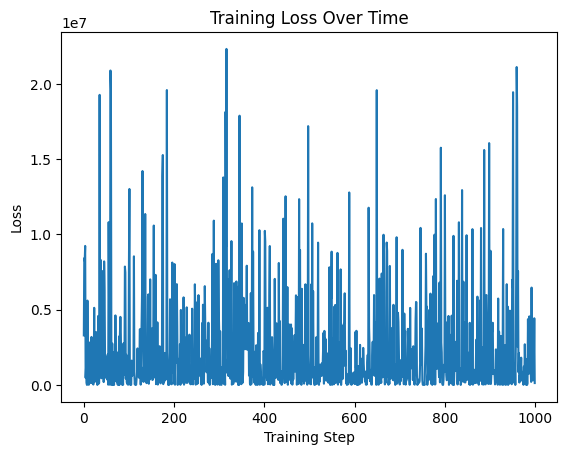

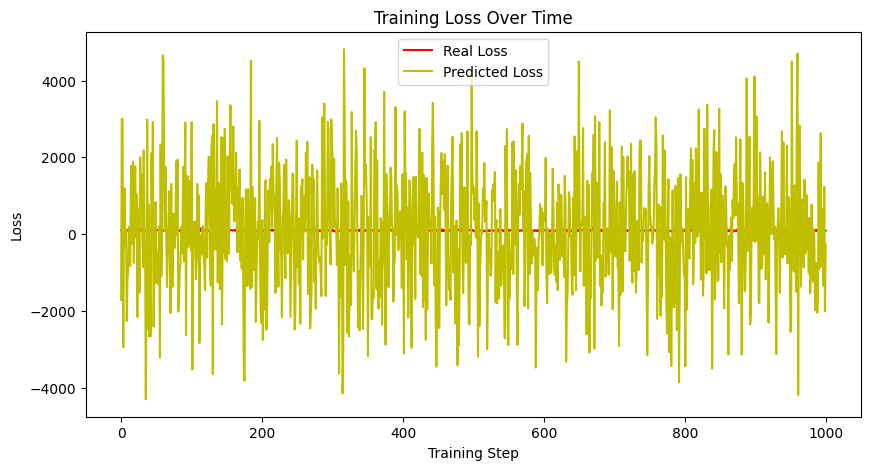

In [15]:
# 实例化模拟器
num_eval_samples = len(eval_sample_ids)
num_train_samples = len(train_sample_ids)
print(num_eval_samples, num_train_samples)
simulator = MetricSimulator(num_eval_samples, num_train_samples)

# 损失函数
loss_fn = nn.MSELoss()

# 优化器
optimizer = optim.Adam(simulator.parameters(), lr=0.001)

# 训练模型
losses = []
M_prev_prev = train_data[0][2]
M_prev = train_data[0][2]

real_losses = []  # 用于记录每个时间步的真实loss
predicted_losses = []  # 用于记录每个时间步的预测loss

for eval_id, train_ids, real_loss in train_data:
    # print(eval_id)
    eval_index = eval_id_to_index[eval_id]
    # print(eval_index)
    # train_index = train_id_to_index[train_ids]
    # print(train_ids)
    train_indexs = [train_id_to_index[key] for key in train_ids if key in train_id_to_index]
    # print(train_indexs)
    real_loss_tensor = torch.tensor(real_loss, dtype=torch.float)
    
    predicted_loss = simulator(eval_index, train_indexs, M_prev, M_prev_prev)

    loss = loss_fn(predicted_loss, real_loss_tensor)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    real_losses.append(real_loss)
    predicted_losses.append(predicted_loss.item())

    losses.append(loss.item())
    M_prev_prev = M_prev
    M_prev = real_loss_tensor
#
plt.plot(losses)
plt.xlabel('Training Step')
plt.ylabel('Loss')
plt.title('Training Loss Over Time')
plt.show()


# 
plt.figure(figsize=(10, 5))
plt.plot(real_losses, 'r', label='Real Loss')  # 
plt.plot(predicted_losses, 'y', label='Predicted Loss')  # 
plt.xlabel('Training Step')
plt.ylabel('Loss')
plt.title('Training Loss Over Time')
plt.legend()
plt.show()